# Run this 
1. this should work flawlessly. tf=2.16.2
2. Dataset should be accessabe. check label stduio url
3. SAVE AS .TF not h5. h5 sux
4. Save as .tflite for publishing to coral.
5. 

In [2]:
%pip install pyyaml h5py  

Note: you may need to restart the kernel to use updated packages.


In [1]:
import trainer
import numpy as np 
import matplotlib.pyplot as plt
import os, h5py  
import tensorflow as tf

In [3]:
def from_the_beginning():
    # List of files to remove
    files_to_remove = [
        'exported_data.json',
        'labels.txt',
        'split_dataset.npy',
        'mfcc_features.npy',
        'model.tflite'
    ]

    # Remove the specified files if they exist
    for file in files_to_remove:
        try:
            if os.path.exists(file):
                os.remove(file)
                print(f"Removed: {file}")
            else:
                print(f"File not found: {file}")
        except Exception as e:
            print(f"Error removing {file}: {e}")
# from_the_beginning()

In [5]:
splited_dataset = trainer.prepare_data()     
mfcc_feature = trainer.get_mfcc(splited_dataset)

Data exported successfully.


In [6]:
def get_fft(features):
    """Compute the FFT of the given features."""
    features = (features - np.mean(features)) / np.std(features)  # Normalize the features
    return np.fft.fft(features)

fft_features = {label: get_fft(features) for label, features in splited_dataset.items()}


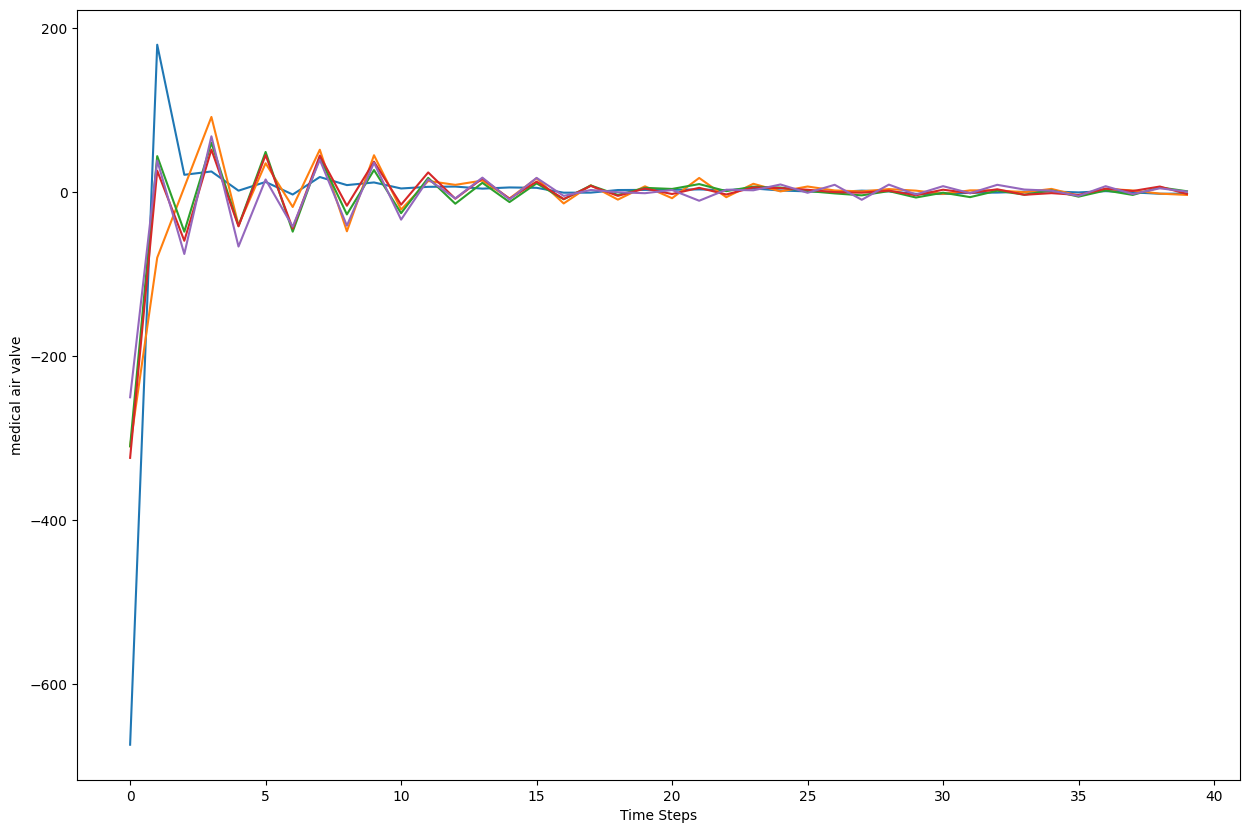

In [7]:
import random

# Plot random samples of values for each key in mfcc_features
fig  = plt.figure(figsize=(15, 10))
ax = fig.add_subplot()
for i, (label, features) in enumerate(mfcc_feature.items()):
    if label not in ['Sink/Water', 'medical air valve']:continue
    # ax = fig.add_subplot(len(mfcc_features), 1, i + 1)
    random_samples = random.sample(list(features), min(5, len(features)))  # Get up to 5 random samples
    for sample in random_samples:
        ax.plot(sample, label=label)

    # plt.title(f'Random Samples for {label}')
    ax.set_xlabel('Time Steps')
    ax.set_ylabel(f'{label}')
    # plt.legend()

# plt.tight_layout()
plt.show()

In [8]:

mfcc_features = {label: (features * 2 if label not in ['Rolling Carts', 'HVAC', 'Speech'] else features) for label, features in mfcc_feature.items()}

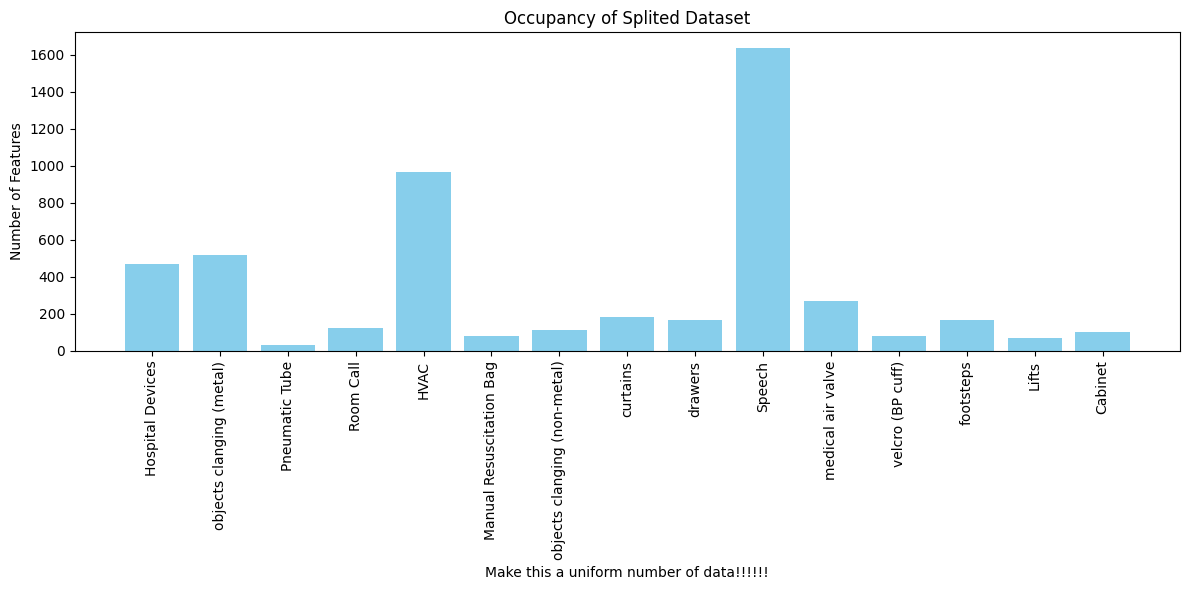

In [9]:
# Visualize the occupancy of the splited dataset
occupancy = {label: len(features) for label, features in mfcc_features.items()}
labels = list(occupancy.keys())
values = list(occupancy.values())

plt.figure(figsize=(12, 6))
plt.bar(labels, values, color='skyblue')
plt.xlabel('Make this a uniform number of data!!!!!!')
plt.ylabel('Number of Features')
plt.title('Occupancy of Splited Dataset')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('occupancy.png')    
plt.show()

In [10]:

x_train, x_test, y_train, y_test, label = trainer.split_data(mfcc_features)
with open('labels.txt', 'w') as f:
    for lbl in label:
        f.write(f"{lbl}\n")



Training set size: 3478
Testing set size: 1491


In [11]:
model = trainer.build_model(x_train, x_test, y_train, y_test)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 40, 32)            128       
                                                                 
 max_pooling1d (MaxPooling1  (None, 20, 32)            0         
 D)                                                              
                                                                 
 dense (Dense)               (None, 20, 32)            1056      
                                                                 
 dropout (Dropout)           (None, 20, 32)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 20, 64)            6208      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 10, 64)            0         
 g1D)                                                   

Epoch 1/100000
425/435 [============================>.] - ETA: 0s - loss: 2.0508 - accuracy: 0.4665
Epoch 1: saving model to checkPoints
435/435 [==============================] - 3s 4ms/step - loss: 2.0250 - accuracy: 0.4698 - val_loss: 0.8396 - val_accuracy: 0.7612
Epoch 2/100000
426/435 [============================>.] - ETA: 0s - loss: 0.9259 - accuracy: 0.6928
Epoch 2: saving model to checkPoints
435/435 [==============================] - 1s 3ms/step - loss: 0.9191 - accuracy: 0.6949 - val_loss: 0.4732 - val_accuracy: 0.8786
Epoch 3/100000
435/435 [==============================] - ETA: 0s - loss: 0.6426 - accuracy: 0.8005
Epoch 3: saving model to checkPoints
435/435 [==============================] - 1s 3ms/step - loss: 0.6426 - accuracy: 0.8005 - val_loss: 0.3323 - val_accuracy: 0.9041
Epoch 4/100000
425/435 [============================>.] - ETA: 0s - loss: 0.4956 - accuracy: 0.8444
Epoch 4: saving model to checkPoints
435/435 [==============================] - 1s 3ms/step - lo

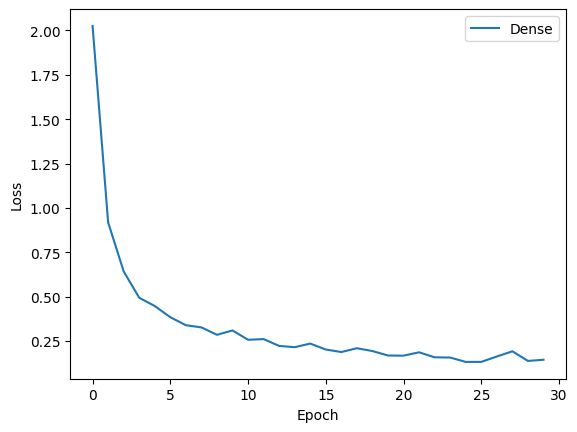

In [12]:
trainer.train(model, x_train, x_test, y_train, y_test)

In [17]:
# trainer.evaluate(model, x_test, y_test, label)
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Make predictions on the test set
predictions = model.predict(x_test)

# Convert predictions from probabilities to class labels
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

# Generate a classification report
from sklearn.metrics import classification_report
report = classification_report(true_classes, predicted_classes, target_names=[label[i] for i in np.unique(true_classes)])
print(report)

# Plot a few test samples and their predicted labels
num_samples = len(true_classes)
plt.figure(figsize=(15, 5))
# for i in range(num_samples):
#     plt.subplot(1, num_samples, i + 1)
#     plt.plot(x_test[i])
# labels = list(report.keys())[:-3]  
# metrics = ['precision', 'recall', 'f1-score', 'support']
# data = np.array([[report[label][metric] for metric in metrics] for label in labels])

# plt.bar(range(num_samples), data, color='blue', alpha=0.5)
# plt.title(f'Predicted: {label[predicted_classes[i]]}')
# plt.axis('off')
# plt.show()


47/47 [==============================] - 0s 2ms/step - loss: 0.0941 - accuracy: 0.9738
Test Loss: 0.0941
Test Accuracy: 0.9738
47/47 [==============================] - 0s 1ms/step
                              precision    recall  f1-score   support

            Hospital Devices       0.99      1.00      0.99       152
    objects clanging (metal)       0.99      0.98      0.99       159
              Pneumatic Tube       0.86      1.00      0.92         6
                   Room Call       1.00      1.00      1.00        47
                        HVAC       0.96      0.96      0.96       289
    Manual Resuscitation Bag       0.95      1.00      0.98        21
objects clanging (non-metal)       1.00      0.93      0.96        40
                    curtains       0.95      1.00      0.97        56
                     drawers       0.93      0.90      0.91        48
                      Speech       0.99      0.98      0.98       475
           medical air valve       1.00      0.98

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

In [18]:
model.save('model.tf', save_format='tf')
print("Model saved as model.tf")

INFO:tensorflow:Assets written to: model.tf\assets


INFO:tensorflow:Assets written to: model.tf\assets


Model saved as model.tf


In [19]:

model.save('my_model.keras')

In [20]:
new_model = tf.keras.models.load_model('my_model.keras')

# Show the model architecture
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 40, 32)            128       
                                                                 
 max_pooling1d (MaxPooling1  (None, 20, 32)            0         
 D)                                                              
                                                                 
 dense (Dense)               (None, 20, 32)            1056      
                                                                 
 dropout (Dropout)           (None, 20, 32)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 20, 64)            6208      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 10, 64)            0         
 g1D)                                                   

In [22]:
# Evaluate the restored model
loss, acc = new_model.evaluate(x_test, y_test, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

print(new_model.predict(x_test).shape)

47/47 - 5s - loss: 0.0941 - accuracy: 0.9738 - 5s/epoch - 113ms/step
Restored model, accuracy: 97.38%
47/47 [==============================] - 0s 1ms/step
(1491, 15)


In [ ]:
model2 = tf.keras.models.load_model('model.tf')
print("Model loaded as model2")

In [23]:

!mkdir -p saved_model
model.save('saved_model/my_model')

INFO:tensorflow:Assets written to: saved_model/my_model\assets


INFO:tensorflow:Assets written to: saved_model/my_model\assets


In [24]:

!mkdir h5_saved_model
model.save('h5_saved_model/my_model.h5')

d:\Projects\soundClassifier\.env\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:


# Convert the model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model2)
tflite_model = converter.convert()

# Save the model to a .tflite file
with open('model2.tflite', 'wb') as f:
    f.write(tflite_model)

print("Model saved as model.tflite")

In [ ]:
# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path='model.tflite')
interpreter.allocate_tensors()

# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("Model loaded successfully.")

In [ ]:
def predict_labels(x_test, model_path='model.tflite'):
    # Load the TFLite model
    interpreter = tf.lite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()

    # Get input and output tensors
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    # Prepare the input data
    x_test_input = np.array([x_test.reshape(1, len(x_test), 1)], dtype=np.float32)
    
    # Set the tensor for the input
    interpreter.set_tensor(input_details[0]['index'], x_test_input[0])

    # Run the model
    interpreter.invoke()

    # Get the output tensor
    output_data = interpreter.get_tensor(output_details[0]['index'])

    # Process the output data
    predicted_classes_tflite = np.argmax(output_data, axis=1)[0]
    # Get the labels from the dataset
    
    return predicted_classes_tflite

In [ ]:
t = len(x_test)
for x, y in zip(x_test, y_test):
    resx = label[predict_labels(x)]
    resy = label[np.argmax(y)]
    if resx != resy:
        print(resx, '\t\t != \t' , resy)
        t -=1

print(t/len(x_test))